-------------------------------

In [197]:
import pandas as pd

df = pd.read_csv('dataset/train_data.txt', sep=" ::: ", header=None)

df.drop([0], axis=1, inplace=True)
df.rename(columns={1: 'title', 2: 'genre', 3: 'description'}, inplace=True)
df = df[["title", "description", "genre"]]

C:\Users\Kamil\AppData\Local\Temp\ipykernel_19276\2958472327.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('dataset/train_data.txt', sep=" ::: ", header=None)


In [198]:
cats = ['drama', 'comedy', 'horror']
df = df[df.genre.isin(cats)]

In [199]:
df['genre'].unique()

array(['drama', 'comedy', 'horror'], dtype=object)

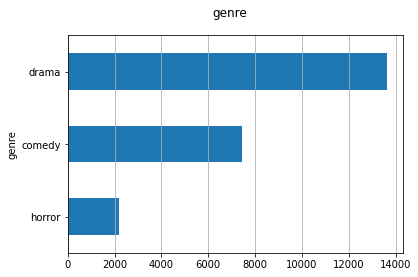

In [200]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.suptitle("genre", fontsize=12)
df["genre"].reset_index().groupby("genre").count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.show()

In [201]:
import nltk, re

def preprocess_sentence(text, stemm=False, lemm=True, stopwords=None): # process one sentence
    # lowercase -> strip -> tokenize -> remove stopwords -> stemm / lemm -> untokenize 

    # lower & strip
    text = text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    # tokenize (convert from string to list)
    text_tokens = text.split()
    
    # remove garbage
    text_tokens = [word.lower().strip('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') for word in text_tokens]

    # remove stopwords
    if stopwords is not None:
        text_tokens = [word for word in text_tokens if word not in stopwords]
                
    ## stemming
    if stemm:
        ps = nltk.stem.porter.PorterStemmer()
        text_tokens = [ps.stem(word) for word in text_tokens]
                
    # lemmatisation 
    if lemm:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        text_tokens = [lem.lemmatize(word) for word in text_tokens]
        
    # back to string from list
    text = " ".join(text_tokens)
    
    return text

def preprocess_text(text, stopwords): 
    
    # split sentences 
    sentences = text.split('.')
    
    # process each sentence
    sentences = [preprocess_sentence(s, stopwords=stopwords) for s in sentences]
    
    result = ". ".join(sentences)
    return result
    

In [202]:
nltk_stopwords = nltk.corpus.stopwords.words("english")
nltk_stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [203]:
df['description'][0]

'Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.'

In [204]:
preprocess_text(df['description'][0], stopwords=nltk_stopwords)

'listening conversation doctor parent 10yearold oscar learns nobody courage tell. week live. furious refuse speak anyone except straighttalking rose lady pink meet hospital stair. christmas approach rose us fantastical experience professional wrestler imagination wit charm allow oscar live life love full company friend pop corn einstein bacon childhood sweetheart peggy blue. '

##### Add 'processed' column to df

In [205]:
df["processed"] = df["description"].apply(lambda x: preprocess_text(x, stopwords=nltk_stopwords))

In [206]:
df.head()

,title,description,genre,processed
0,Oscar et la dame rose (2009),Listening in to a conversation between his doc...,drama,listening conversation doctor parent 10yearold...
3,The Secret Sin (1915),To help their unemployed father make ends meet...,drama,help unemployed father make end meet edith twi...
4,The Unrecovered (2007),The film's title refers not only to the un-rec...,drama,film title refers unrecovered body ground zero...
6,"""Pink Slip"" (2009)",In tough economic times Max and Joey have all ...,comedy,tough economic time max joey run idea discover...
9,Spirits (2014/I),Four high school students embark on a terrifyi...,horror,four high school student embark terrifying jou...


In [207]:
from sklearn import model_selection

# split dataset
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)
# get target
y_train = df_train["genre"].values
y_test = df_test["genre"].values

### Prepare corpus for word2vec training [training set]


In [208]:
processed = df_train["processed"]

def tokenize_text(text_or_path, file_input=False): # find better solution for large scale texts (batch reading from os)
   
   text = ''
   if file_input:
      with open(text_or_path) as f:
         text = f.read()
         text = text.replace('\n', '')
   else:
      text = text_or_path
         
   # tokenize text to sentences
   sentences = text.split(sep='.')
   sentences = [s.strip() for s in sentences]
   
   # tokenize sentences to words
   sentences_tokenized = [s.split(sep=' ') for s in sentences]
   
   #for i, s in enumerate(sentences_tokenized):
   #   sentences_tokenized[i] = [word.lower().strip('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') for word in s]
      
   return sentences_tokenized

# tokenize all joined preprocessed descriptions
corpus_tokenized = tokenize_text(''.join(processed))
corpus_tokenized[0]

['young',
 'country',
 'girl',
 'come',
 'big',
 'city',
 'get',
 'involved',
 'unscrupulous',
 'people',
 'end',
 'broke',
 'stranded']

In [209]:
len(processed)

16284

In [210]:
len(corpus_tokenized)

88865

## PREPARE NEW DESCRIPTION COLUMN FOR TRAINING.

### Add 'processed_as_sentences' column to df -> this column has processed descriptions(multisentence) joined into one sentence descritpions

In [211]:
processed = df_train["processed"]

def multi_sentence_to_one(multi_sen_arr): # find better solution for large scale texts (batch reading from os)
    return [multi_sen.replace('.', ' ') for multi_sen in multi_sen_arr]

# tokenize all joined preprocessed descriptions
processed_as_sentences = multi_sentence_to_one(processed)
len(processed_as_sentences)
processed_as_sentences[0]

'young country girl come big city get involved unscrupulous people end broke stranded  however friendly millionaire happens come along        '

In [212]:
df["desc_prepared"] = df["processed"].apply(lambda x: x.replace('.', ' '))

In [213]:
descriptions_corpus = '.'.join(df["desc_prepared"])

#### fitting word2vec

model is trained on the whole training corpus divided into sentences -> keeping words in their sentences to learn their meanings 

In [214]:
from gensim.models import Word2Vec
nlp = None
load = True

#loading cell
if load:
    nlp = Word2Vec.load("three/word2vec.model")
else:
    nlp = Word2Vec(sentences=corpus_tokenized, vector_size=300, window=8, workers=4, sg=1, epochs=30) # sg: 1-skip gram 0-cbow
    nlp.save("three/word2vec.model")


In [215]:
nlp.wv['man'][:10]

array([-0.06942783,  0.27525133,  0.12439331,  0.16781127, -0.2523476 ,
       -0.25592536,  0.19220048,  0.27168217,  0.22203434,  0.05036501],
      dtype=float32)

# visualisation

c:\source\ai-nlp\env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\source\ai-nlp\env\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\Kamil\AppData\Local\Temp\ipykernel_19276\1131722588.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_["input"].iloc[0:1] = 1


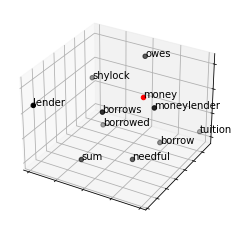

In [216]:
from sklearn import manifold

word = "money"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in nlp.wv.most_similar(word, topn=10)]
X = nlp.wv[tot_words]

## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

### TRANSFORM PREPROCESSED CORPUS INTO LIST OF SEQUENCES

Teraz stworzony zostanie słownik dla corpusu który powstał z opisów zbioru treningowego. W tym słowniku każde słowo z korpusu dostanie swój indeks. Następnie za pomocą tych indeksów przedstawione zostaną sentencje zawierające się w opisach.

create dictionary from training set descriptions. In this dictionary each words gets its own index

In [217]:
df.processed

0        listening conversation doctor parent 10yearold...
3        help unemployed father make end meet edith twi...
4        film title refers unrecovered body ground zero...
6        tough economic time max joey run idea discover...
9        four high school student embark terrifying jou...
                               ...                        
54200    father savagely assaulted family lumberyard pa...
54207    man woman meet identification spouse dead body...
54209    shortlived nbc live sitcom centered bonino wor...
54210    next generation exploitation. sister kapa bay ...
54212    walter vivian live country difficult time keep...
Name: processed, Length: 23264, dtype: object

In [218]:
from tensorflow.keras import preprocessing as k_preprocessing

# tokenize vocab
tokenizer = k_preprocessing.text.Tokenizer(lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(df_train.processed) # corpus_tokenized can be tested as well
dic_vocabulary = tokenizer.word_index

In [219]:
print(len(dic_vocabulary.keys()))

for key in list(dic_vocabulary.keys())[50:52]:
    print(key, dic_vocabulary[key])


66166
becomes 51
end 52


#### map words in sentences to indexes in deictionary

In [220]:
# create sequence of dictionary ids in place of words
lst_text2seq = tokenizer.texts_to_sequences(df_train.processed)
lst_text2seq[4]
len(lst_text2seq)

16284

#### pad sentences to equal length -> number of features (words) for each intput

In [221]:
# padding sequence      
X_train = k_preprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=40, padding="post", truncating="post")
X_train

array([[    8,   156,    19, ...,     0,     0,     0],
       [ 2696, 16444,  5764, ...,     0,     0,     0],
       [23988,  4312, 33270, ...,    36,  4536,  3099],
       ...,
       [10199,    52, 18208, ...,    28,   109,     3],
       [11833,  1539,   548, ...,     0,     0,     0],
       [ 9361,  2807,   281, ...,     0,     0,     0]])

In [222]:
X_train.shape

(16284, 40)

### Feature matrix for each sentence (i.e. lengths of sentences)

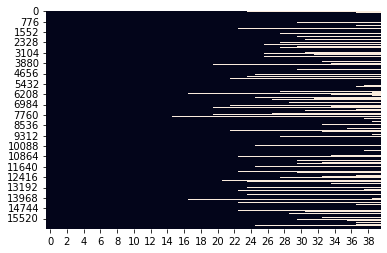

In [223]:
import seaborn as sns
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

### Prepare feature matrix for X_test

In [224]:
# create sequence of dictionary ids in place of words
lst_text2seq = tokenizer.texts_to_sequences(df_test.processed)
len(lst_text2seq)

6980

In [225]:
# padding sequence      
X_test = k_preprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=40, padding="post", truncating="post")
X_test

array([[12741,     1, 23149, ...,  4698,  2550,   279],
       [ 9570,  2677, 64623, ...,  8243,     0,     0],
       [13967,   463,   215, ...,  1211,   730, 26835],
       ...,
       [   58,    90,   117, ...,     0,     0,     0],
       [    1, 11061,    30, ...,  2109,  7171,  6416],
       [   13,  4445,    25, ...,     0,     0,     0]])

In [226]:
X_test.shape

(6980, 40)

### Feature matrix for each sentence (i.e. lengths of sentences)

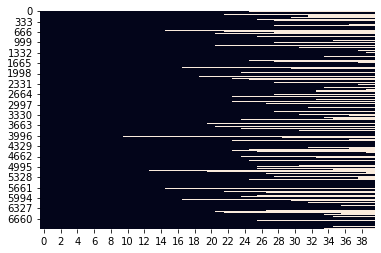

In [227]:
import seaborn as sns
sns.heatmap(X_test==0, vmin=0, vmax=1, cbar=False)
plt.show()

### Create the matrix of embedding (weight matrix)

In [228]:
import numpy as np

## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp.wv[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [229]:
idx = dic_vocabulary['dog']
embeddings[idx].shape

(300,)

## Prepare TF layers model

In [230]:
embeddings.shape

(66167, 300)

In [231]:
from tensorflow.keras import models, layers


def get_model(verbose = False):
    x_input_layer = layers.Input(shape=(40,))

    # embedding
    x_layers = layers.Embedding(input_dim=embeddings.shape[0],
                                output_dim=embeddings.shape[1],
                                weights=[embeddings],
                                input_length=40, trainable=False)(x_input_layer)

    # calculations
    x_layers = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                            return_sequences=True))(x_layers)
    x_layers = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x_layers)

    # activation

    x_layers = layers.Dense(64, activation='relu')(x_layers)
    y_out = layers.Dense(len(cats), activation='softmax')(x_layers)

    # create model

    model = models.Model(x_input_layer, y_out)
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
    
    if verbose:
        model.summary()
    
    return model


## Encode categories

In [232]:
np.unique(y_train)

array(['comedy', 'drama', 'horror'], dtype=object)

In [233]:
categories_dict = {label:n for n,label in 
                   enumerate(cats)}

# map categories to numbers
y_train = np.array([categories_dict[y] for y in y_train])

In [234]:
y_train

array([0, 0, 0, ..., 0, 0, 1])

## Train model

In [235]:
from tensorflow.keras.models import load_model

training = None
model = None
load = True

#loading cell
if load:
    # load here
    model = load_model('three/keras_model')
else:
    model = get_model()
    training = model.fit(x=X_train, y=y_train, batch_size=256, 
                        epochs=10, shuffle=True, verbose=0, 
                        validation_split=0.3)
    model.save("three/keras_model")

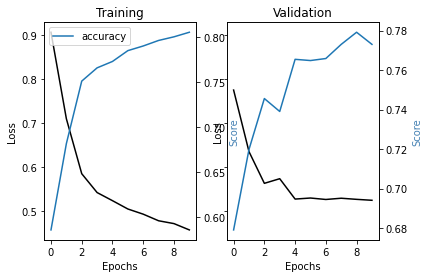

In [ ]:
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [ ]:
categories_dict_inversed = {v:k for k,v in categories_dict.items()}

In [ ]:
## test
predicted_prob = model.predict(X_test)
predicted = [categories_dict_inversed[np.argmax(pred)] for pred in predicted_prob]

In [ ]:
len(y_test)

6980

In [ ]:
len(predicted)

6980

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, predicted)
print(conf_matrix)

[[1530  682   26]
 [ 601 3414   54]
 [  79  180  414]]


<AxesSubplot:>

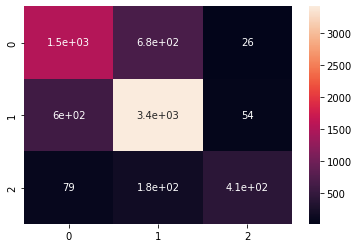

In [ ]:
import seaborn as sb
#correlogram
sb.heatmap(conf_matrix, annot=True)

[[0.68364611 0.30473637 0.01161752]
 [0.14770214 0.83902679 0.01327107]
 [0.11738484 0.26745914 0.61515602]]
{'drama': 0, 'comedy': 1, 'horror': 2}


<AxesSubplot:>

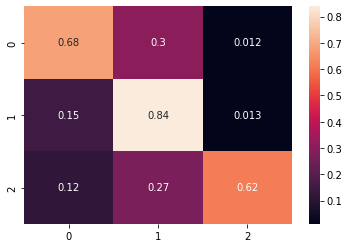

In [ ]:
conf_matrix_as_percentage = conf_matrix

conf_matrix_as_percentage = np.array([[num/np.sum(row) for num in row] for row in conf_matrix_as_percentage])
print(conf_matrix_as_percentage)
print(categories_dict)
sb.heatmap(conf_matrix_as_percentage, annot=True)

## Predicting user provided descriptions

####  input -> process -> embed -> predict

In [ ]:
def predict_film_category(description, verbose=False): # hardcoded for one input -> can be transformed to array of inputs easily
    description_p = preprocess_sentence(description, stopwords=nltk_stopwords)
    description_p = [description_p.split()]
    
    
    if verbose:
        d = description.split()
        print(f'Input: {d}')
        print(f'Processed: {description_p[0]}')
        print(f'Input length: {len(d)}')
        print(f'Processed length: {len(description_p[0])}')
        print()
        
    # create sequence of dictionary ids in place of words
    input_seq = tokenizer.texts_to_sequences(description_p)

    # padding sequence      
    input_seq = k_preprocessing.sequence.pad_sequences(input_seq, 
                        maxlen=40, padding="post", truncating="post")
    
    if verbose:
        print(f'Padded sequence: {input_seq}')
        
    class_probability_dist = model.predict(input_seq)
    prediction = categories_dict_inversed[np.argmax(class_probability_dist)]
    
        
    if verbose:
        for k in categories_dict.keys(): # padd to chars
            print(k, end='\t\t')
        print()
        
        for prob in class_probability_dist[0]:
            print(prob, end='\t')
        print()
        
        print(f'Predicted category: {prediction}')
        
        
    return prediction

In [ ]:
predict_film_category('A special military unit fights a powerful, out-of-control supercomputer and hundreds of scientists who have mutated into flesh-eating creatures after a laboratory accident.', verbose=True)

Input: ['A', 'special', 'military', 'unit', 'fights', 'a', 'powerful,', 'out-of-control', 'supercomputer', 'and', 'hundreds', 'of', 'scientists', 'who', 'have', 'mutated', 'into', 'flesh-eating', 'creatures', 'after', 'a', 'laboratory', 'accident.']
Processed: ['special', 'military', 'unit', 'fight', 'powerful', 'outofcontrol', 'supercomputer', 'hundred', 'scientist', 'mutated', 'flesheating', 'creature', 'laboratory', 'accident']
Input length: 23
Processed length: 14

Padded sequence: [[  433   725  2545   163   799 10155     1  1960  1411 12632 10669  1078
   6488   253     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
drama		comedy		horror		
0.80361176	0.18243241	0.013955897	
Predicted category: drama


'drama'

In [ ]:
predict_film_category('A story about young man named James. He lives with his mother and uncle Joe.', verbose=True)


Input: ['A', 'story', 'about', 'young', 'man', 'named', 'James.', 'He', 'lives', 'with', 'his', 'mother', 'and', 'uncle', 'Joe.']
Processed: ['story', 'young', 'man', 'named', 'james', 'life', 'mother', 'uncle', 'joe']
Input length: 15
Processed length: 9

Padded sequence: [[ 11  10  12 160 497   2  25 339 568   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]
drama		comedy		horror		
0.6289843	0.358777	0.012238729	
Predicted category: drama


'drama'